# Plot the classifier-generated scores in map view
For now, using the pygmt package, but maybe something like geopandas is better here.

In [1]:
from glob import glob
import pygmt
import pandas as pd
import xarray as xr
import os
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
scores_dir='/swot2/features/tsv_all/runtime_scores/'
data_dir='/swot2/features/tsv_all/runtime_data'
files=glob(scores_dir + '*.pkl')

def read_pkl(file):
    with open(file,'rb') as pkl_file:
        D=pkl.load(pkl_file)
    human=D[1][:,0]
    preds=D[1][:,1:]
    return human,preds

def get_feature_from_score(score_file):
    fname = os.path.basename(score_file)
    fname = fname.replace('_scores.pkl','')
    fname = fname.replace('test_','')
    return data_dir + '/' + fname

def get_lld(file):
    fname = get_feature_from_score(file)
    with open(fname,'rb') as pkl_file:
        features, _, _ = pkl.load(pkl_file)
    features = np.asarray(features)
    # throw out the '9998' records
    features = features[np.nonzero(features[:,4] != 9998)]
    return features[:,0:3]

# will need to check that len(lld) == len(preds)

In [3]:
good=[]
total=[]
for file in files:
    #print(file,end='\n')
    human,preds=read_pkl(file)

    good.append(sum(human))
    total.append(human.shape[0])

In [4]:
frac_good=np.array([good[i]/total[i] for i in range(len(total))])

## Labeled Good > 0.9 (and not = 1.0)
Basically need to find a good way to visualize the scores in map view. I'll grab a cruise segment the same way as done in the Analysis nb.

In [5]:
i=0

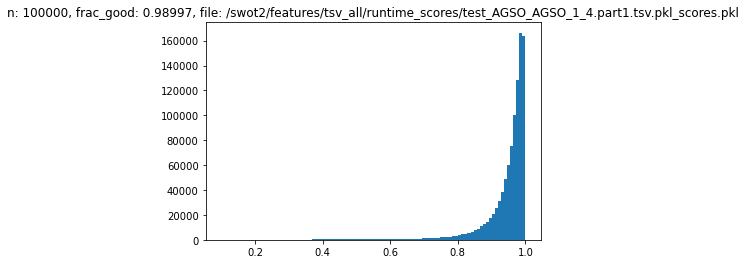

In [6]:
i+=1
while frac_good[i] < 0.9 or frac_good[i] == 1.0:
    i+=1

human,preds=read_pkl(files[i])
lld = get_lld(files[i])
_mean=np.mean(preds,axis=1)
_std=np.std(preds,axis=1)

fig, ax = plt.subplots()
ax.hist(preds.flatten(),bins=100);
ax.set_title('n: {}, frac_good: {}, file: {}'.format(str(human.shape[0]),str(frac_good[i]),files[i]))
plt.show()

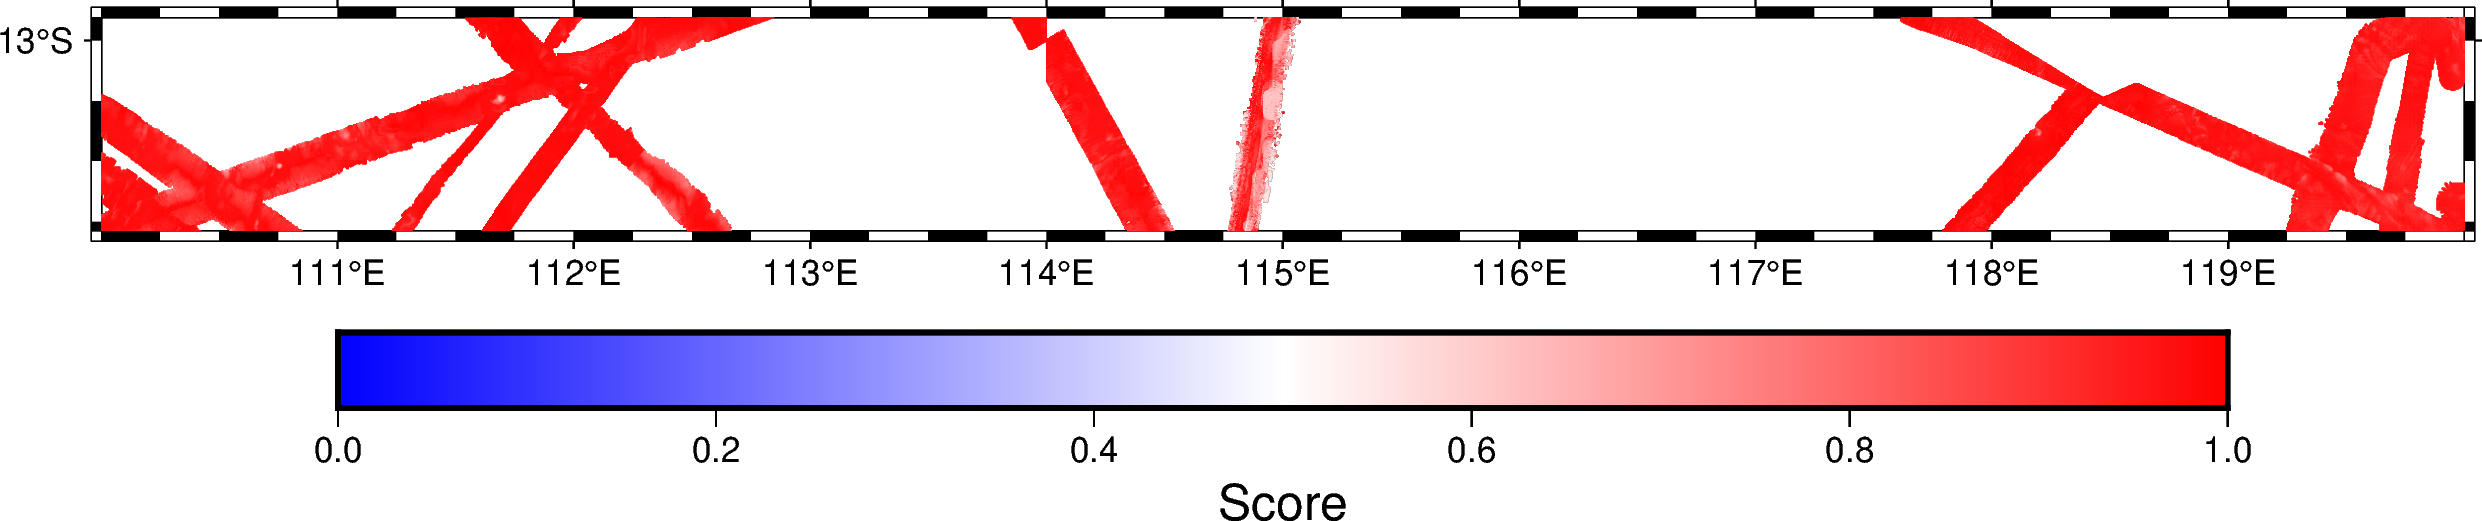

In [25]:
region = [np.min(lld[:,0]), np.max(lld[:,0]), np.min(lld[:,1]), np.max(lld[:,1])]
projection = 'M20c'

fig = pygmt.Figure()
pygmt.makecpt(cmap='polar', series=[0, 1])
fig.basemap(
    region=region,
    projection=projection,
    frame=['af']
)
# only plot the labeled bad points
fig.plot(
    x=lld[np.nonzero(human == 0)[0],0],
    y=lld[np.nonzero(human == 0)[0],1],
    style='p'
)
fig.plot(
    x=lld[:,0],
    y=lld[:,1],
    style='p',
    color=_mean,
    cmap=True,
    transparency=0
)
fig.colorbar(
    cmap=True,
    frame=["xa0.2f0.2+lScore"],
    position='JBC'
) # colormap is way too big but I'm not going to bother tweaking it right now
fig.savefig("score-map.png")
fig.show(width=1000)


This is just the mean score plotted as a shaded point. The problem here is we want to show the human label and the score, but those necessarily occupy the same space, so it's not easy to show by plotting only the points. You can do a little better by tweaking the transparency of the overlying score points, but that makes the score values more difficult to interpret.

## Contoured score map
I'll try making a contour map of the scores. To regularize the contouring, we need to grid.

In [9]:
region = [np.min(lld[:,0]), np.max(lld[:,0]), np.min(lld[:,1]), np.max(lld[:,1])]
projection = 'M20c'

preproc = pygmt.blockmedian(
    region=region,
    x=lld[:,0],
    y=lld[:,1],
    z=_mean,
    spacing='15s+e',
    registration='p'
)

gridded = pygmt.surface(
    data=preproc,
    spacing='15s',
    region=region
)

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.


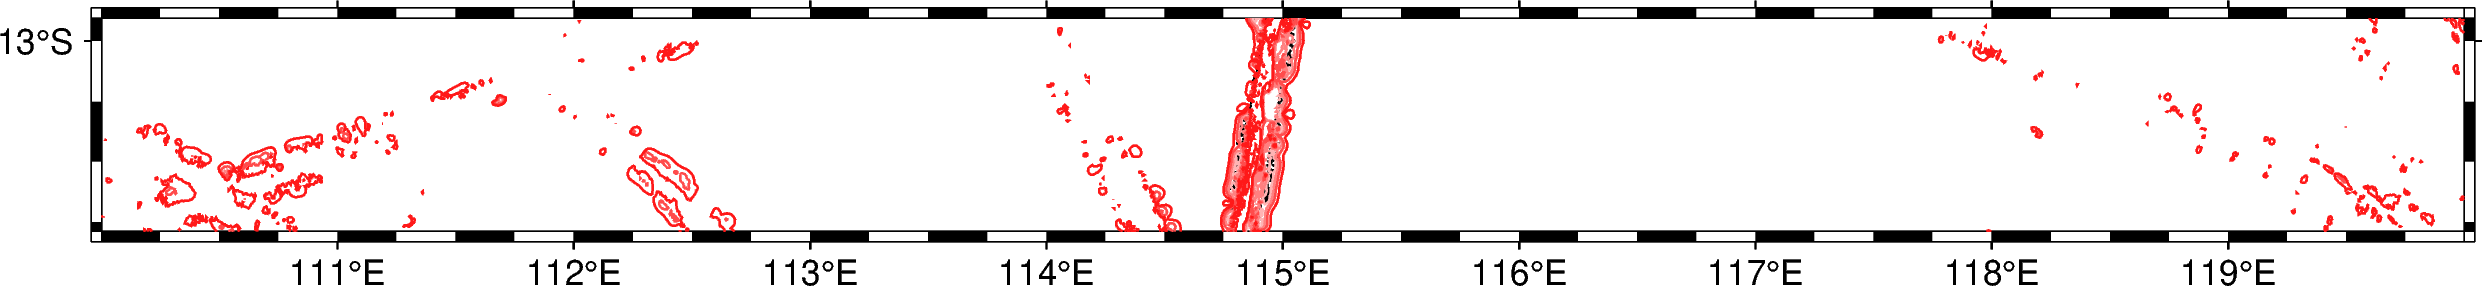

In [60]:
fig = pygmt.Figure()
pygmt.makecpt(cmap='polar', series=[0, 1])
fig.basemap(
    region=region,
    projection=projection,
    frame=['af']
)
# only plot the labeled bad points
fig.plot(
    x=lld[np.nonzero(human == 0)[0],0],
    y=lld[np.nonzero(human == 0)[0],1],
    style='p',
)
fig.grdcontour(
    grid=gridded,
    interval='intervals.cpt',
    pen='0.5p+cl',
    annotation='-'
)

fig.savefig("score-contour-and-label.png")
fig.show(width=1000)

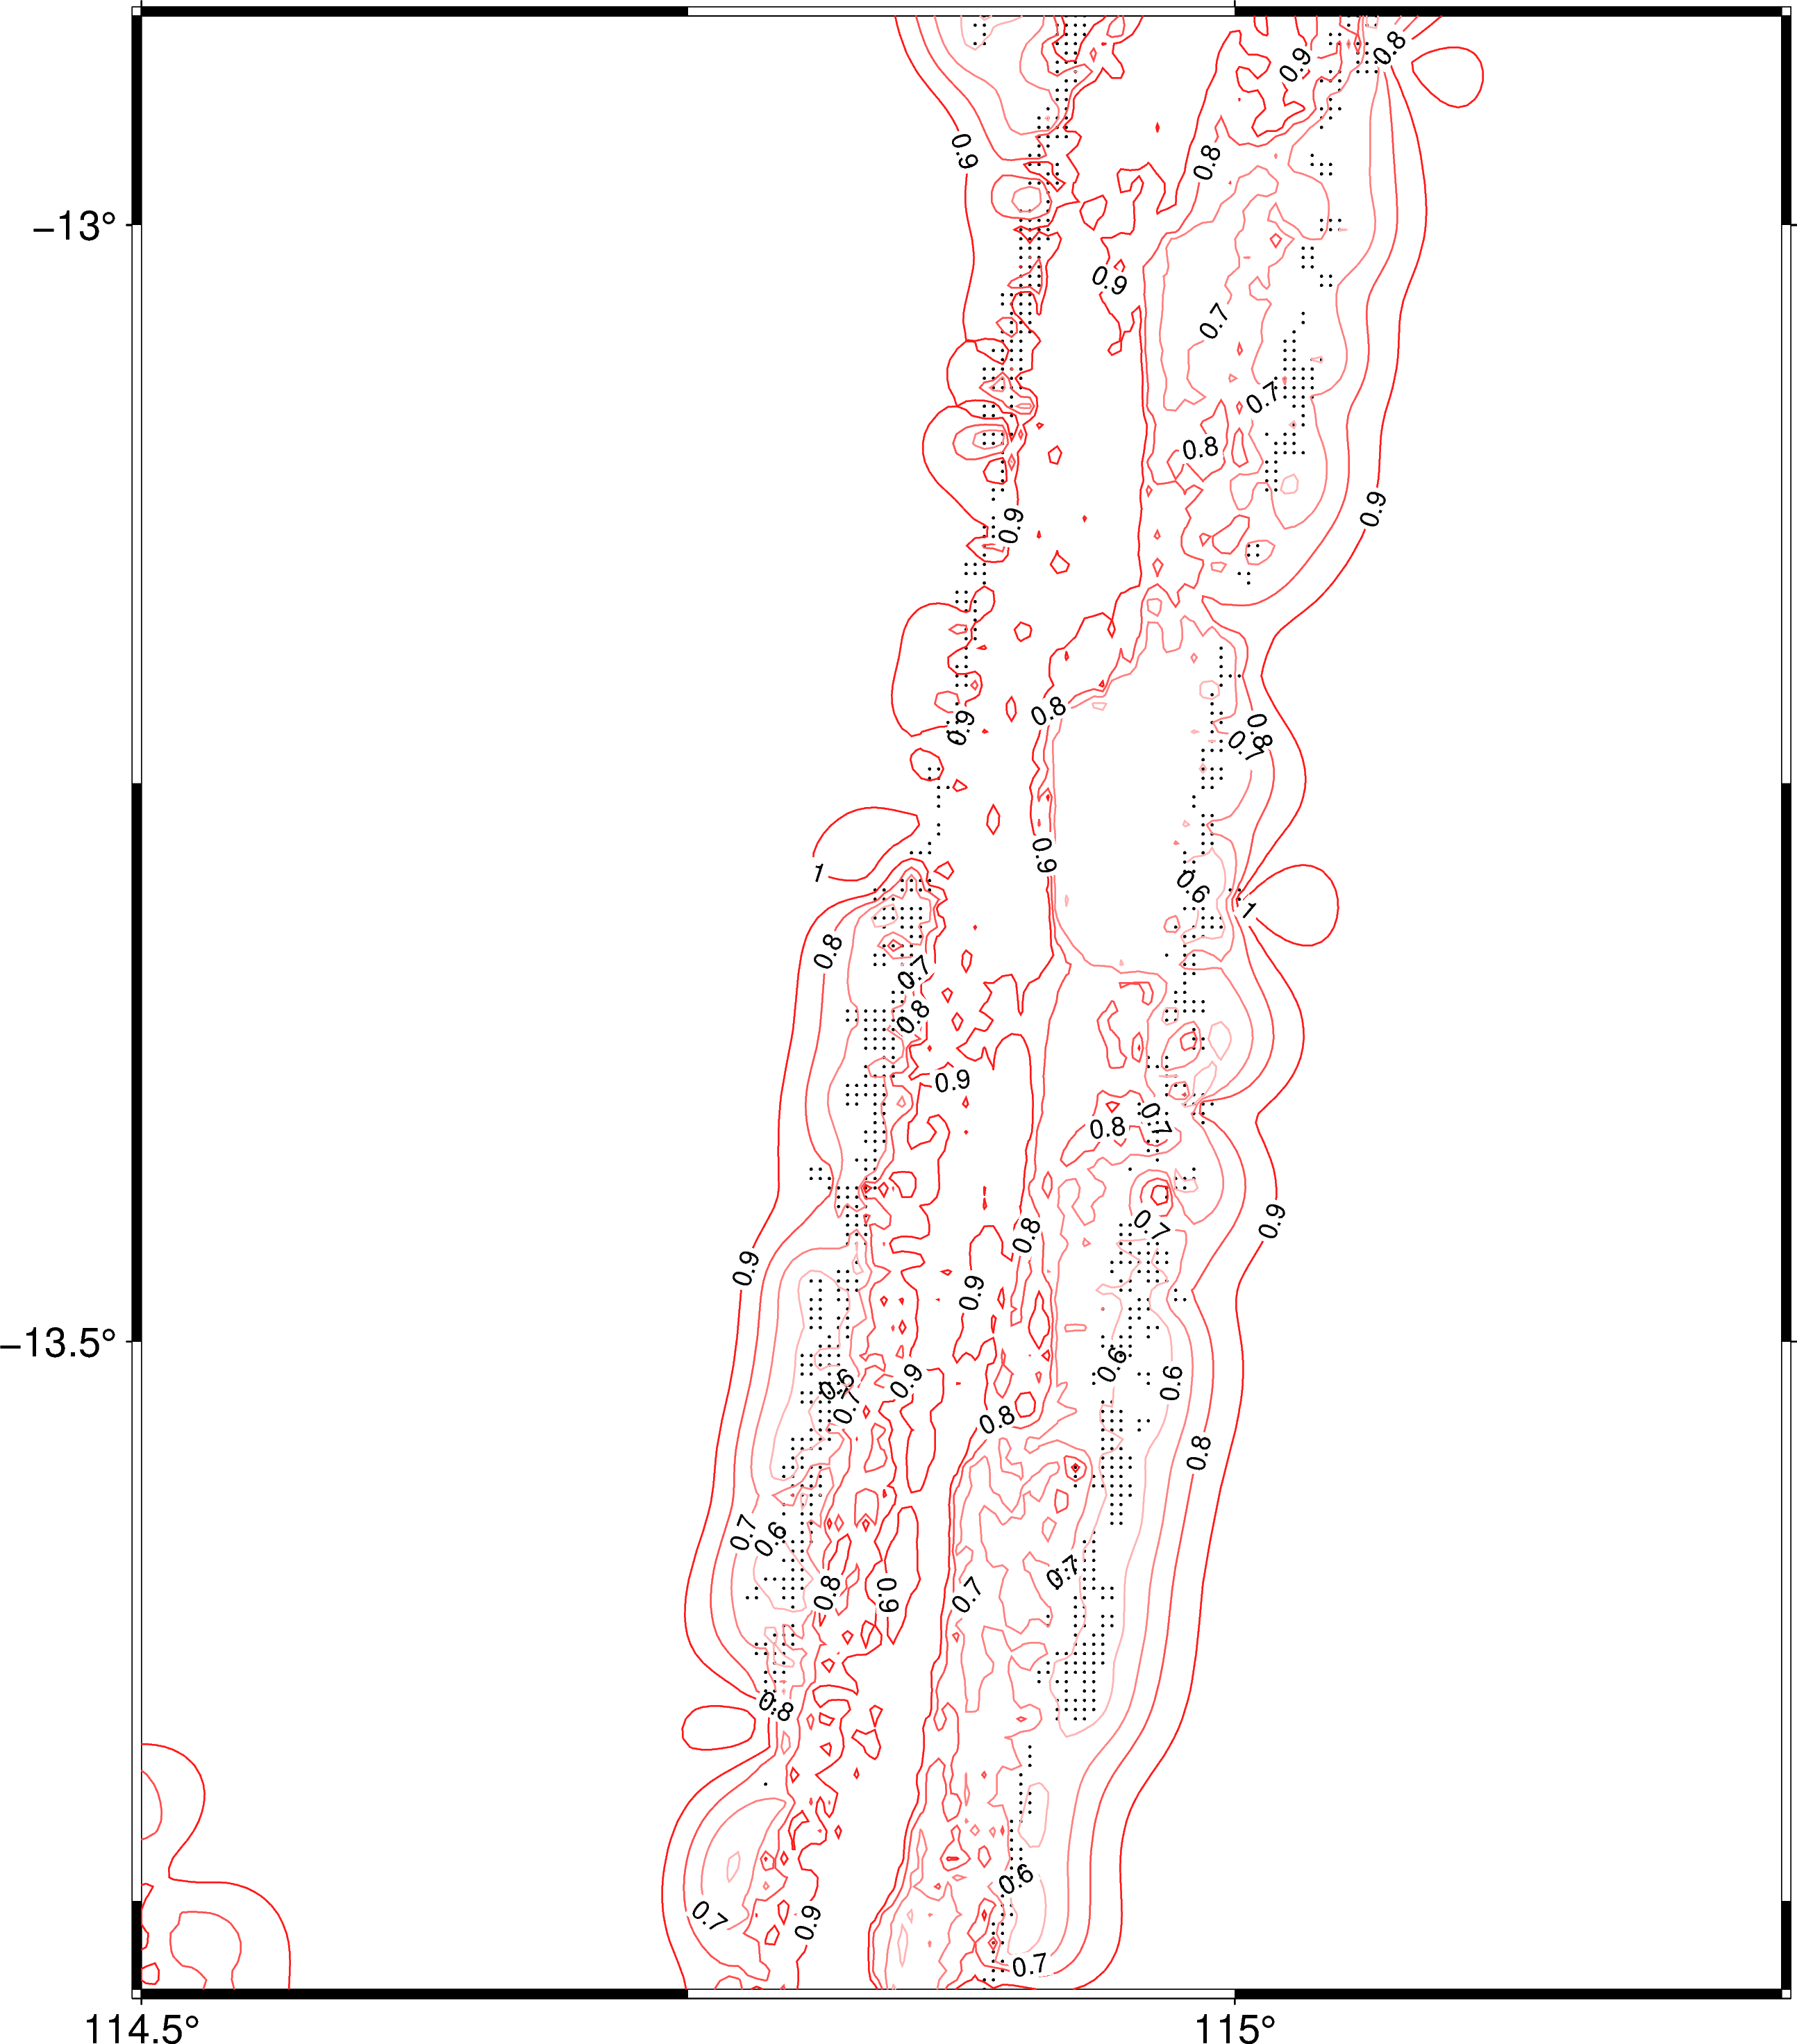

In [69]:
region=[114.5, 115.25, np.min(lld[:,1]), np.max(lld[:,1])]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='D')
pygmt.config(FONT_ANNOT_PRIMARY="14p,Helvetica,black")
fig.basemap(
    region=region,
    projection=projection,
    frame=['a0.5f0.25']
)
# only plot the labeled bad points
fig.plot(
    x=lld[np.nonzero(human == 0)[0],0],
    y=lld[np.nonzero(human == 0)[0],1],
    style='c1p',
    color='black'
)
fig.grdcontour(
    grid=gridded,
    interval='intervals.cpt',
    pen='0.5p+cl',
)

#fig.savefig("score-contour-and-label.png")
fig.show(width=1000)

A zoomed-in look at the labeled bad points.

## Other visualizations
Using some other plotting packages-- haven't used geoplot before, and I can see now it's not very good for our purposes here. And it's MUCH slower than pygmt.

In [28]:
import geoplot
import geopandas as gpd

In [58]:
df = pd.DataFrame({
    'Longitude': lld[:,0],
    'Latitude': lld[:,1],
    'Score': _mean
})
scores = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude,df.Latitude)
)

<AxesSubplot:>

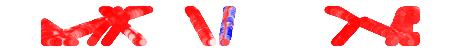

In [59]:
geoplot.pointplot(
    scores,
    hue='Score',
    cmap='bwr'
)

While this works for visualizing the results qualitatively, there aren't hard numbers I can report here which is the goal. So what would work? A convolution?